# Import Libraries

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

# Idea
- Look at which which abnormal tests are correlated
- Look at the patients for those tests, and see what diagnosis
- Look at if there are common prescriptions for those drugs

# Import Data

In [120]:
# Patient Data
patients = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')

# Prescription Data
prescriptions = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv')

# Lab Events Data
lab_items = pd.read_csv('mimic-iii-clinical-database-demo-1.4/D_LABITEMS.csv')
lab_events = pd.read_csv('mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv', parse_dates=['charttime'])

# Procedures Data
procedures = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PROCEDURES_ICD.csv')
procedures_labels = pd.read_csv('mimic-iii-clinical-database-demo-1.4/D_ICD_PROCEDURES.csv')

# Admissions Data
admissions = pd.read_csv('mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')

In [121]:
from datetime import datetime
# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
patients["age"] = patients.apply(lambda row: calculate_age(row["dob"], row["dod"]), axis=1)

# Display the updated DataFrame
print(patients.head())

   row_id  subject_id gender                  dob                  dod  \
0    9467       10006      F  2094-03-05 00:00:00  2165-08-12 00:00:00   
1    9472       10011      F  2090-06-05 00:00:00  2126-08-28 00:00:00   
2    9474       10013      F  2038-09-03 00:00:00  2125-10-07 00:00:00   
3    9478       10017      F  2075-09-21 00:00:00  2152-09-12 00:00:00   
4    9479       10019      M  2114-06-20 00:00:00  2163-05-15 00:00:00   

              dod_hosp              dod_ssn  expire_flag  age  
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1   71  
1  2126-08-28 00:00:00                  NaN            1   36  
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1   87  
3                  NaN  2152-09-12 00:00:00            1   77  
4  2163-05-15 00:00:00  2163-05-15 00:00:00            1   48  


## First, I identify the tests that have the highest percentage of abnormal results

In [122]:
# Step 1: Get unique lab tests with their counts
test_counts = lab_events.groupby('itemid').agg(
    total_count=('itemid', 'count')
).reset_index()

# Step 2: Add count of abnormal results
abnormal_counts = lab_events[lab_events['flag'] == 'abnormal'].groupby('itemid').agg(
    abnormal_count=('itemid', 'count')
).reset_index()

# Step 3: Merge the counts
test_stats = test_counts.merge(abnormal_counts, on='itemid', how='left')
test_stats['abnormal_count'] = test_stats['abnormal_count'].fillna(0)

# Step 4: Add lab test labels
test_stats = test_stats.merge(lab_items[['itemid', 'label']], on='itemid', how='left')

# Step 5: Calculate percentage and sort
test_stats['abnormal_percentage'] = (test_stats['abnormal_count'] / test_stats['total_count'] * 100).round(2)
test_stats = test_stats.sort_values('abnormal_count', ascending=False)

# Print top 10 for verification
print("Top 10 lab tests by abnormal count:")
print(test_stats.head(10)[['itemid', 'label', 'total_count', 'abnormal_count', 'abnormal_percentage']])

Top 10 lab tests by abnormal count:
     itemid              label  total_count  abnormal_count  \
265   51221         Hematocrit         2317          2185.0   
266   51222         Hemoglobin         2024          1914.0   
307   51279    Red Blood Cells         2007          1881.0   
93    50931            Glucose         2121          1489.0   
305   51277                RDW         2005          1363.0   
147   51006      Urea Nitrogen         2158          1262.0   
302   51274                 PT         1378          1117.0   
81    50912         Creatinine         2175          1023.0   
297   51265     Platelet Count         2088           944.0   
321   51301  White Blood Cells         2021           871.0   

     abnormal_percentage  
265                94.30  
266                94.57  
307                93.72  
93                 70.20  
305                67.98  
147                58.48  
302                81.06  
81                 47.03  
297                45.21  


In [123]:
# Get top 10 tests by abnormal count
top_10_tests = test_stats.nlargest(10, 'abnormal_count')

# Create bar chart
fig = px.bar(
    top_10_tests,
    x='label',
    y='abnormal_count',
    title='Top 10 Lab Tests by Abnormal Results Count',
    labels={
        'label': 'Lab Test',
        'abnormal_count': 'Number of Abnormal Results'
    },
    hover_data={
        'total_count': True,
        'abnormal_count': True,
        'abnormal_percentage': ':.2f',
        'itemid': True
    }
)

# Update layout for better readability
fig.update_layout(
    xaxis_tickangle=45,
    height=600
)

fig.show()

Notes:

Looking at the data, we see that Hematocrit, Hemoglobin, and Red Blood Cells are the Lab tests that have the highest number of abnormal tests. Additionally, each of them have high percentage of abnormal tests. Meaning of they were abnormal over 90% of the time they were conducted.

## I will explore patients who tested abnormal for Hematocrit (itemid = 51221), Hemoglobin (itemid = 51222), and Red Blood Cells (itemid = 51279), in more detail.

#### Getting insurance, religion, and ethnicity, for each patient

In [124]:
# Get the first occurrence of insurance, religion, and ethnicity for each subject_id
first_admission_info = admissions.groupby('subject_id').agg({
    'insurance': 'first',
    'religion': 'first',
    'ethnicity': 'first'
}).reset_index()

# Merge with patients dataframe
patients = patients.merge(first_admission_info, on='subject_id', how='left')

#### Analyzing the Patients that Tested Positive for Hematocrit, Hemoglobin, and Red Blood Cells

In [125]:
# Get itemids for each test
test_ids = {
    'Hematocrit': 51221,
    'Hemoglobin': 51222,
    'Red Blood Cells': 51279
}

# Create counts for each test type
for test_name, test_id in test_ids.items():
    # Get total test counts
    total_counts = lab_events[lab_events['itemid'] == test_id]\
        .groupby('subject_id').size()\
        .reset_index(name=f'total_{test_name.lower().replace(" ", "_")}_tests')
    
    # Get abnormal test counts
    abnormal_counts = lab_events[
        (lab_events['itemid'] == test_id) & 
        (lab_events['flag'] == 'abnormal')
    ].groupby('subject_id').size()\
        .reset_index(name=f'abnormal_{test_name.lower().replace(" ", "_")}_tests')
    
    # Merge with patients dataframe
    patients = patients.merge(total_counts, on='subject_id', how='left')
    patients = patients.merge(abnormal_counts, on='subject_id', how='left')
    
    # Fill NaN values with 0
    patients[f'total_{test_name.lower().replace(" ", "_")}_tests'] = \
        patients[f'total_{test_name.lower().replace(" ", "_")}_tests'].fillna(0)
    patients[f'abnormal_{test_name.lower().replace(" ", "_")}_tests'] = \
        patients[f'abnormal_{test_name.lower().replace(" ", "_")}_tests'].fillna(0)
    
    # Add percentage column
    test_name_lower = test_name.lower().replace(" ", "_")
    patients[f'{test_name_lower}_abnormal_percentage'] = (
        patients[f'abnormal_{test_name_lower}_tests'] / 
        patients[f'total_{test_name_lower}_tests'] * 100
    ).fillna(0)

# Display the first few rows to verify
print(patients.head())

   row_id  subject_id gender                  dob                  dod  \
0    9467       10006      F  2094-03-05 00:00:00  2165-08-12 00:00:00   
1    9472       10011      F  2090-06-05 00:00:00  2126-08-28 00:00:00   
2    9474       10013      F  2038-09-03 00:00:00  2125-10-07 00:00:00   
3    9478       10017      F  2075-09-21 00:00:00  2152-09-12 00:00:00   
4    9479       10019      M  2114-06-20 00:00:00  2163-05-15 00:00:00   

              dod_hosp              dod_ssn  expire_flag  age insurance  ...  \
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1   71  Medicare  ...   
1  2126-08-28 00:00:00                  NaN            1   36   Private  ...   
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1   87  Medicare  ...   
3                  NaN  2152-09-12 00:00:00            1   77  Medicare  ...   
4  2163-05-15 00:00:00  2163-05-15 00:00:00            1   48  Medicare  ...   

                ethnicity total_hematocrit_tests  abnormal_hematocrit_test

#### Analyzing Percentage of Abnormal tests as a Function of Age

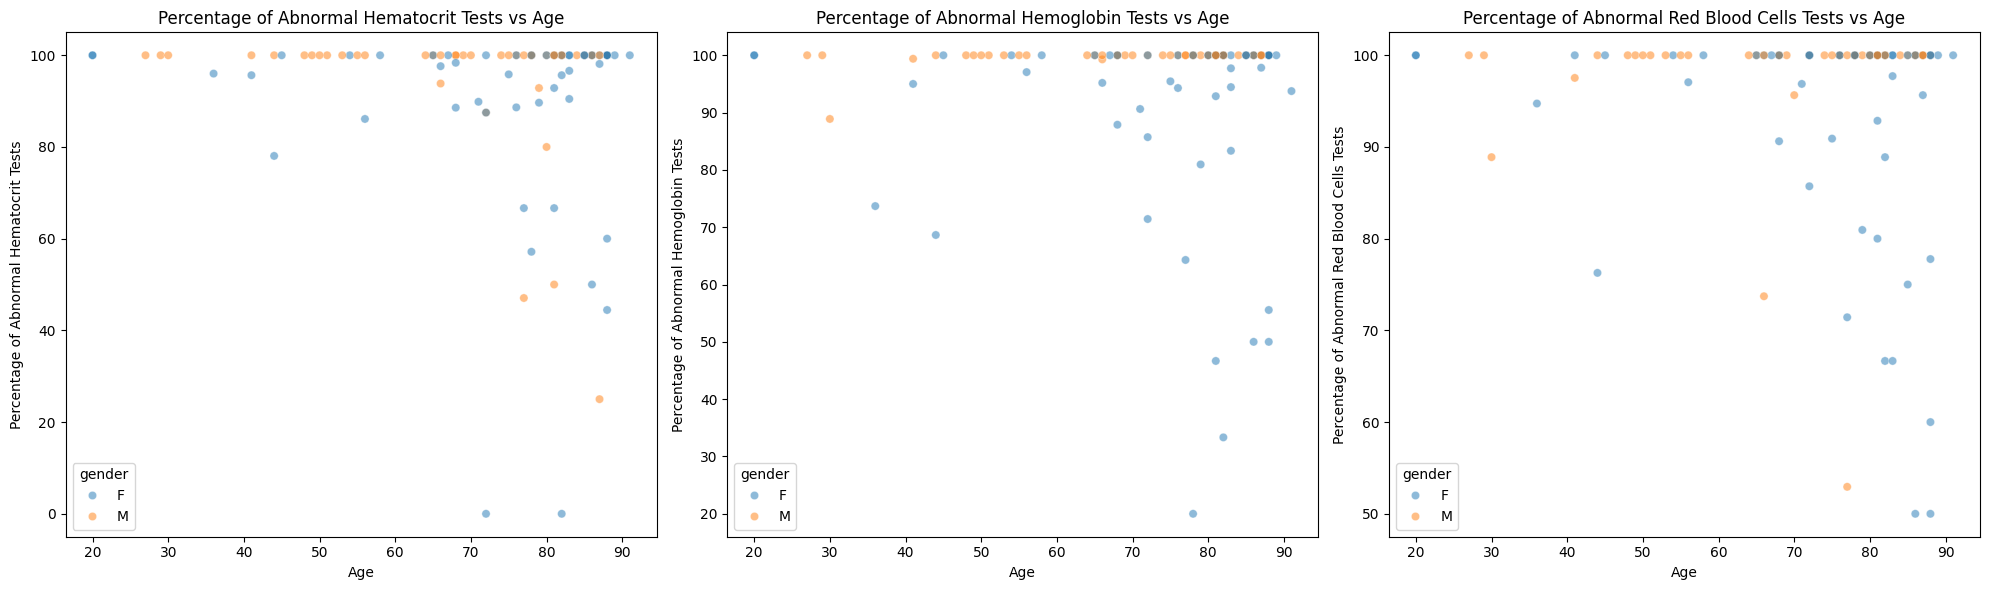

In [129]:
# Filter by age, only keep rows with <120 age
patients = patients[patients['age'] < 120]

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot for Hematocrit
sns.scatterplot(
    data=patients[patients['total_hematocrit_tests'] > 0],
    x='age',
    y='hematocrit_abnormal_percentage',
    hue='gender',
    alpha=0.5,
    ax=ax1
)
ax1.set_title('Percentage of Abnormal Hematocrit Tests vs Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage of Abnormal Hematocrit Tests')

# Plot for Hemoglobin
sns.scatterplot(
    data=patients[patients['total_hemoglobin_tests'] > 0],
    x='age',
    y='hemoglobin_abnormal_percentage',
    hue='gender',
    alpha=0.5,
    ax=ax2
)
ax2.set_title('Percentage of Abnormal Hemoglobin Tests vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Percentage of Abnormal Hemoglobin Tests')

# Plot for Red Blood Cells
sns.scatterplot(
    data=patients[patients['total_red_blood_cells_tests'] > 0],
    x='age',
    y='red_blood_cells_abnormal_percentage',
    hue='gender',
    alpha=0.5,
    ax=ax3
)
ax3.set_title('Percentage of Abnormal Red Blood Cells Tests vs Age')
ax3.set_xlabel('Age')
ax3.set_ylabel('Percentage of Abnormal Red Blood Cells Tests')

# Adjust layout and display
plt.tight_layout()
plt.show()

Note:

It is interesting to note that for all 3 tests, and for ages 70 and above, Males tend to have a higher percentage of abnormal Hematocrit, Hemoglobin, and Red Blood Cells tests compared to Females.

In [ ]:
patients_over_70 = patients[patients["age"] > 70]


#### Analyzing Percentage of Abnormal tests as a Function of Insurance

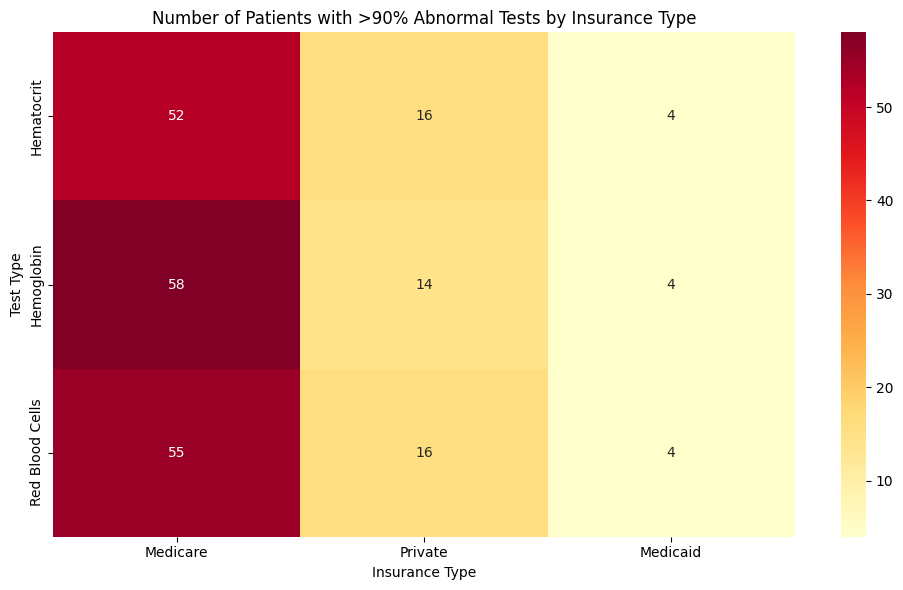

In [ ]:
# look at the patients with >90%. Then compare the drugs they were administered. See if there are commonalities in drugs, diagnosis, etc.
# Filter rows where any of the specified columns have values > 90%
filtered_patients_over_90 = patients[
    (patients['hematocrit_abnormal_percentage'] > 90) |
    (patients['hemoglobin_abnormal_percentage'] > 90) |
    (patients['red_blood_cells_abnormal_percentage'] > 90)
]

# Create a pivot table for the heatmap
heatmap_data = pd.DataFrame()

# Create separate rows for each test type
for test_type, column in {
    'Hematocrit': 'hematocrit_abnormal_percentage',
    'Hemoglobin': 'hemoglobin_abnormal_percentage', 
    'Red Blood Cells': 'red_blood_cells_abnormal_percentage'
}.items():
    # Count patients by insurance type for each test
    test_counts = filtered_patients_over_90[filtered_patients_over_90[column] > 90]['insurance'].value_counts()
    heatmap_data[test_type] = test_counts

# Fill NaN values with 0 since these represent no patients meeting criteria
heatmap_data = heatmap_data.fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Patients with >90% Abnormal Tests by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Test Type')
plt.tight_layout()
plt.show()



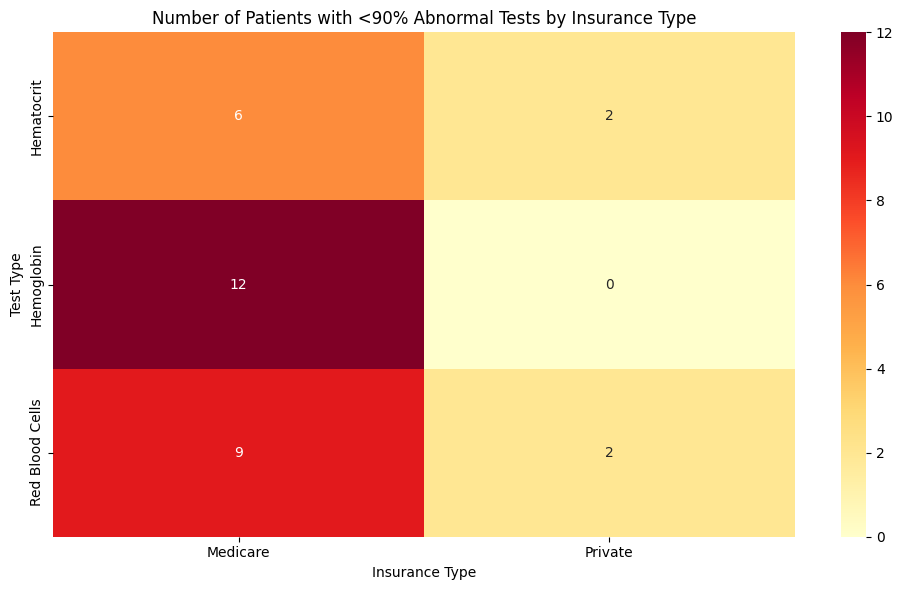

In [133]:
# look at the patients with <90%. Then compare the drugs they were administered. See if there are commonalities in drugs, diagnosis, etc.
# Filter rows where any of the specified columns have values > 90%
filtered_patients_under_90 = patients[
    (patients['hematocrit_abnormal_percentage'] < 90) |
    (patients['hemoglobin_abnormal_percentage'] < 90) |
    (patients['red_blood_cells_abnormal_percentage'] < 90)
]

# Create a pivot table for the heatmap
heatmap_data = pd.DataFrame()

# Create separate rows for each test type
for test_type, column in {
    'Hematocrit': 'hematocrit_abnormal_percentage',
    'Hemoglobin': 'hemoglobin_abnormal_percentage', 
    'Red Blood Cells': 'red_blood_cells_abnormal_percentage'
}.items():
    # Count patients by insurance type for each test
    test_counts = filtered_patients_under_90[filtered_patients_under_90[column] > 90]['insurance'].value_counts()
    heatmap_data[test_type] = test_counts

# Fill NaN values with 0 since these represent no patients meeting criteria
heatmap_data = heatmap_data.fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Patients with <90% Abnormal Tests by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Test Type')
plt.tight_layout()
plt.show()



Note:

This data shows that most of the patients with a greater than 90% of abnormal tests have Medicare, followed by Private insurance, and then Medicaid.

Note that a patient can have abnormal tests for multiple Tests, but cannot have multiple types of insurance. A patient can belong to multiple rows, within the same column, but not multiple columns within the same row.

#### Analyzing Percentage of Abnormal tests as a Function of Religion

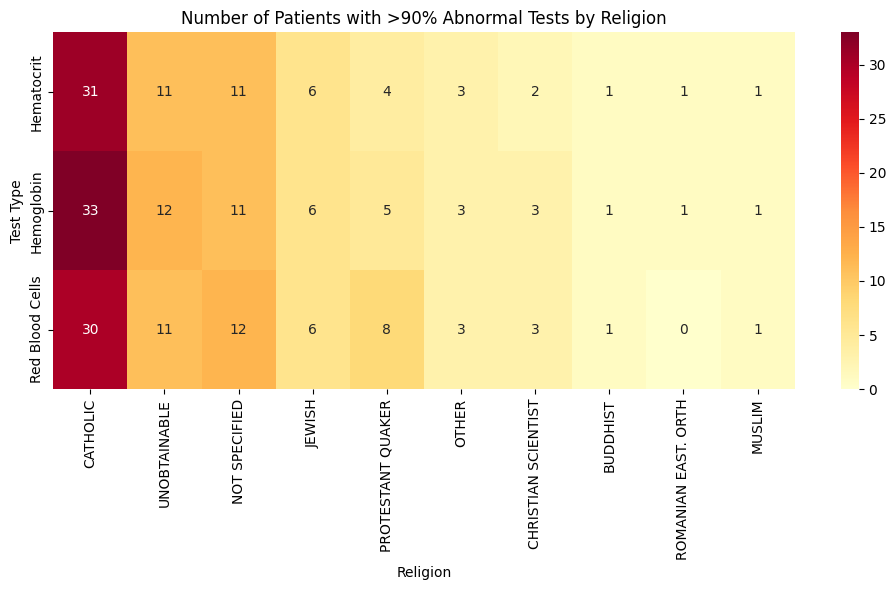

In [134]:
# look at the patients with >90%. Then compare the drugs they were administered. See if there are commonalities in drugs, diagnosis, etc.
# Filter rows where any of the specified columns have values > 90%
filtered_patients_over_90 = patients[
    (patients['hematocrit_abnormal_percentage'] > 90) |
    (patients['hemoglobin_abnormal_percentage'] > 90) |
    (patients['red_blood_cells_abnormal_percentage'] > 90)
]

# Create a pivot table for the heatmap
heatmap_data = pd.DataFrame()

# Create separate rows for each test type
for test_type, column in {
    'Hematocrit': 'hematocrit_abnormal_percentage',
    'Hemoglobin': 'hemoglobin_abnormal_percentage', 
    'Red Blood Cells': 'red_blood_cells_abnormal_percentage'
}.items():
    # Count patients by insurance type for each test
    test_counts = filtered_patients_over_90[filtered_patients_over_90[column] > 90]['religion'].value_counts()
    heatmap_data[test_type] = test_counts

# Fill NaN values with 0 since these represent no patients meeting criteria
heatmap_data = heatmap_data.fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Patients with >90% Abnormal Tests by Religion')
plt.xlabel('Religion')
plt.ylabel('Test Type')
plt.tight_layout()
plt.show()



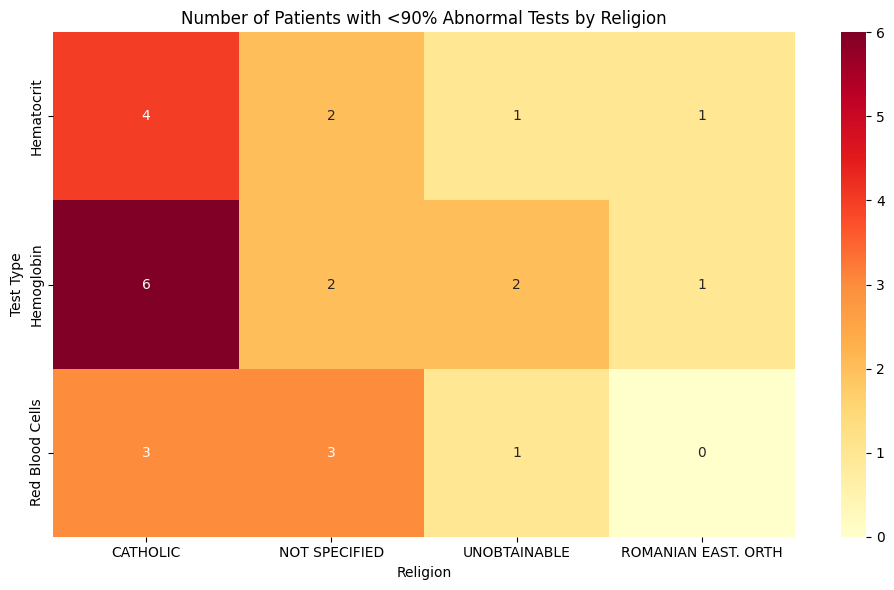

In [136]:
# look at the patients with <90%. Then compare the drugs they were administered. See if there are commonalities in drugs, diagnosis, etc.
# Filter rows where any of the specified columns have values > 90%
filtered_patients_under_90 = patients[
    (patients['hematocrit_abnormal_percentage'] < 90) |
    (patients['hemoglobin_abnormal_percentage'] < 90) |
    (patients['red_blood_cells_abnormal_percentage'] < 90)
]

# Create a pivot table for the heatmap
heatmap_data = pd.DataFrame()

# Create separate rows for each test type
for test_type, column in {
    'Hematocrit': 'hematocrit_abnormal_percentage',
    'Hemoglobin': 'hemoglobin_abnormal_percentage', 
    'Red Blood Cells': 'red_blood_cells_abnormal_percentage'
}.items():
    # Count patients by insurance type for each test
    test_counts = filtered_patients_under_90[filtered_patients_under_90[column] > 90]['religion'].value_counts()
    heatmap_data[test_type] = test_counts

# Fill NaN values with 0 since these represent no patients meeting criteria
heatmap_data = heatmap_data.fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Patients with <90% Abnormal Tests by Religion')
plt.xlabel('Religion')
plt.ylabel('Test Type')
plt.tight_layout()
plt.show()



Note:

This data shows that most of the patients with a greater than 90% of abnormal tests are Catholic.

## Analyzing Diagnosis Data